# Pylops - seismic inversion - blocky

### Author: M.Ravasi

In this notebook we will consider again the problem of post-stack seismic inversion but we will look into blocky models and how we can tailor our inversion to estimate models that satisfy this prior information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 1D

Create velocity and density profiles

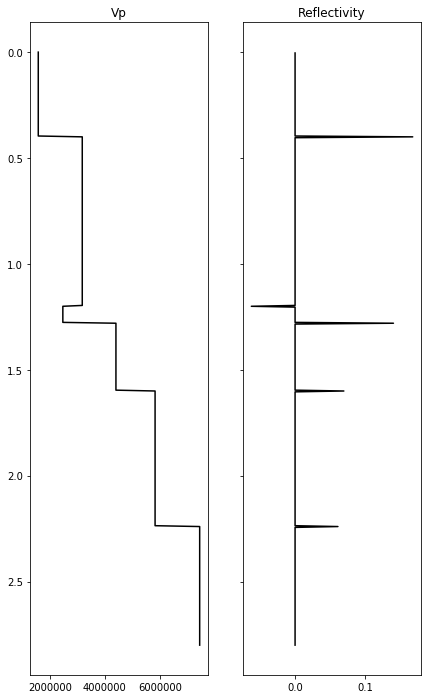

In [2]:
np.random.seed(0)

nt0 = 701
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200*np.ones(nt0)
vp[100:300] = 1700
vp[300:320] = 1500
vp[320:400] = 2000
vp[400:550] = 2300
vp[500:560] = 2300
vp[560:]= 2600

rho=vp*1.1
ai = rho*vp

r = (ai[1:] - ai[0:-1]) / (ai[1:] + ai[0:-1])/2
m = np.log(ai)

fig, axs = plt.subplots (1, 2, figsize=(7,12), sharey=True)
axs[0].plot(ai,  t0, 'k')
axs[0].set_title('Vp')
axs[1].plot(r,  t0[1:], 'k')
axs[1].set_title('Reflectivity')
axs[1].invert_yaxis()

Define wavelet, operators and data

In [3]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

In [4]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nt0)
dottest(PPop, nt0, nt0, verb=True)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nt0, explicit=True)
dottest(PPop, nt0, nt0, verb=True)

# data
d = PPop*m.flatten()
d_dense = PPop_dense*m.flatten()
dn_dense = d_dense + np.random.normal(0, 3e-2, d_dense.shape)

Dot test passed, v^T(Opu)=4.181531 - u^T(Op^Tv)=4.181531
Dot test passed, v^T(Opu)=48.041178 - u^T(Op^Tv)=48.041178


Invert for model(s)

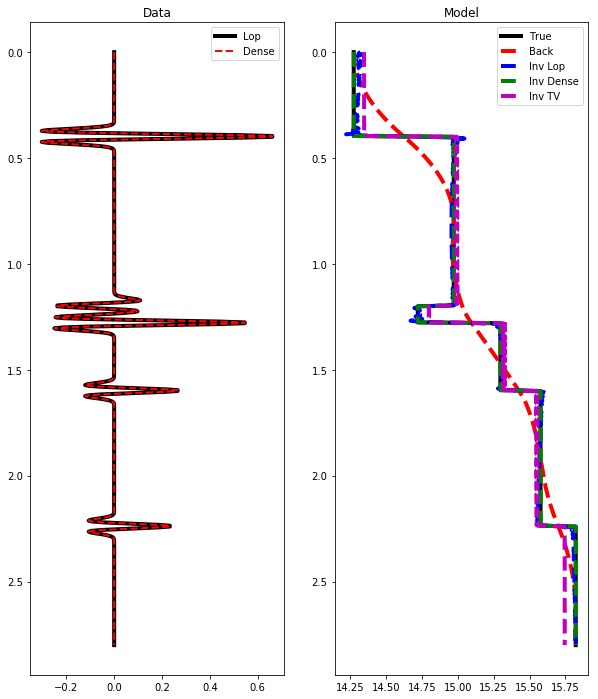

In [5]:
nsmooth = 100
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m)

# solve lop
d0 = PPop*mback
dr = d - d0
minv = lsqr(PPop, dr, iter_lim=2000)[0]
minv = mback + minv

# solve dense
d0_dense = PPop*mback
dr_dense = d_dense - d0_dense
minv_dense = lstsq(PPop_dense.A, dr_dense)[0]
minv_dense = mback + minv_dense

# solve blocky
mu = 0.01
lamda = 0.05
niter = 50
niterinner = 3
Dop = FirstDerivative(nt0, edge=True)
minv_blocky, niter_blocky = SplitBregman(PPop, [Dop], d_dense, niter, niterinner, mu=mu, 
                                         epsRL1s=[lamda], x0=mback,
                                         tol=1e-4, tau=1., **dict(iter_lim=30, damp=1e-3))

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m, t0, 'k', lw=4, label='True')
axs[1].plot(mback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=4, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--g', lw=4, label='Inv Dense')
axs[1].plot(minv_blocky, t0, '--m', lw=4, label='Inv TV')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

Same on noisy data

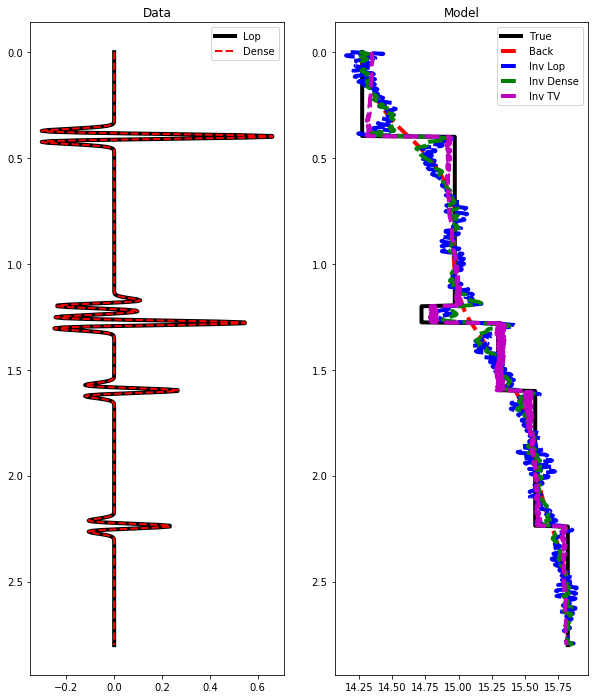

In [6]:
nsmooth = 100
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m)

# solve lop
d0 = PPop*mback
dr = dn_dense - d0
minv = lsqr(PPop, dr, damp=1e-1, iter_lim=2000)[0]
minv = mback + minv

# solve dense
d0_dense = PPop*mback
dr_dense = dn_dense - d0_dense
minv_dense = lstsq(np.dot(PPop_dense.A.T, PPop_dense.A) + 1e-1*np.eye(nt0), 
                   np.dot(PPop_dense.A.T, dr_dense))[0]
minv_dense = mback + minv_dense

# solve blocky
mu = 0.01
lamda = 0.05
niter = 5
niterinner = 10
Dop = FirstDerivative(nt0, edge=True)
minv_blocky, niter_blocky = SplitBregman(PPop, [Dop], dn_dense, niter, niterinner, mu=mu, 
                                         epsRL1s=[lamda], x0=mback, restart=True,
                                         tol=1e-4, tau=1., **dict(iter_lim=30, damp=1e-3))
#minv_blocky, niter_blocky = SplitBregman(PPop, [Dop], dn_dense, niter, niterinner, mu=mu, 
#                                         epsRL1s=[lamda], x0=mback, restart=False,
#                                         tol=1e-4, tau=1., **dict(iter_lim=10, damp=1e-3))

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m, t0, 'k', lw=4, label='True')
axs[1].plot(mback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=4, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--g', lw=4, label='Inv Dense')
axs[1].plot(minv_blocky, t0, '--m', lw=4, label='Inv TV')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

## 2D

In [7]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model'])
nx, nz = len(x), len(z)

In [8]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=nx)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# data
d = (PPop*m.flatten()).reshape(nz,nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)

n = np.random.normal(0, 1e-1, d_dense.shape)
dn = d + n
dn_dense = d_dense + n

Dot test passed, v^T(Opu)=669.396536 - u^T(Op^Tv)=669.396536
Dot test passed, v^T(Opu)=-1030.191341 - u^T(Op^Tv)=-1030.191341


In [9]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

d_0_dense = PPop_dense*mback.flatten()
d_0_lop = PPop*mback.flatten()

In [14]:
# solve blocky
mu=.1
epsRL1s=0.1
epsRL2s=0.2,
niter = 5
niterinner = 10

Dop = FirstDerivative(nz*nx, [nz, nx], dir=0, edge=True)
Dlatop = SecondDerivative(nz*nx, [nz, nx], dir=1, edge=True)


minv_blocky, niter_blocky = SplitBregman(PPop, [Dop], d.flatten(), niter, niterinner, RegsL2=[Dlatop], 
                                         mu=.1, epsRL1s=[0.1], epsRL2s=[0.2], 
                                         x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                         **dict(iter_lim=5, damp=1e-3))
minv_blocky = minv_blocky.reshape(nz, nx)

minvn_blocky, nitern_blocky = SplitBregman(PPop, [Dop], dn.flatten(), niter, niterinner, RegsL2=[Dlatop], 
                                          mu=.1, epsRL1s=[0.1], epsRL2s=[0.4], 
                                          x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                          **dict(iter_lim=5, damp=1e-3))
minvn_blocky = minvn_blocky.reshape(nz, nx)

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 440000 rows and 440000 cols
niter_outer =   5     niter_inner =  10
mu = 1.00e-01         epsL1 = [0.1]       tol = 1.00e-04
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   6.07853e-01        3.650e+00        5.249e+03
     2   6.08995e-01        3.146e+00        4.789e+03
     3   6.11284e-01        3.012e+00        4.462e+03
     4   6.14377e-01        3.010e+00        4.248e+03
     5   6.17825e-01        3.071e+00        4.085e+03
Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 440000 rows and 440000 cols
niter_outer =   5     niter_inner =  10
mu = 1.00e-01         epsL1 = [0.1]       tol = 1.00e-04
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   5.54783e-01        2.040e+02

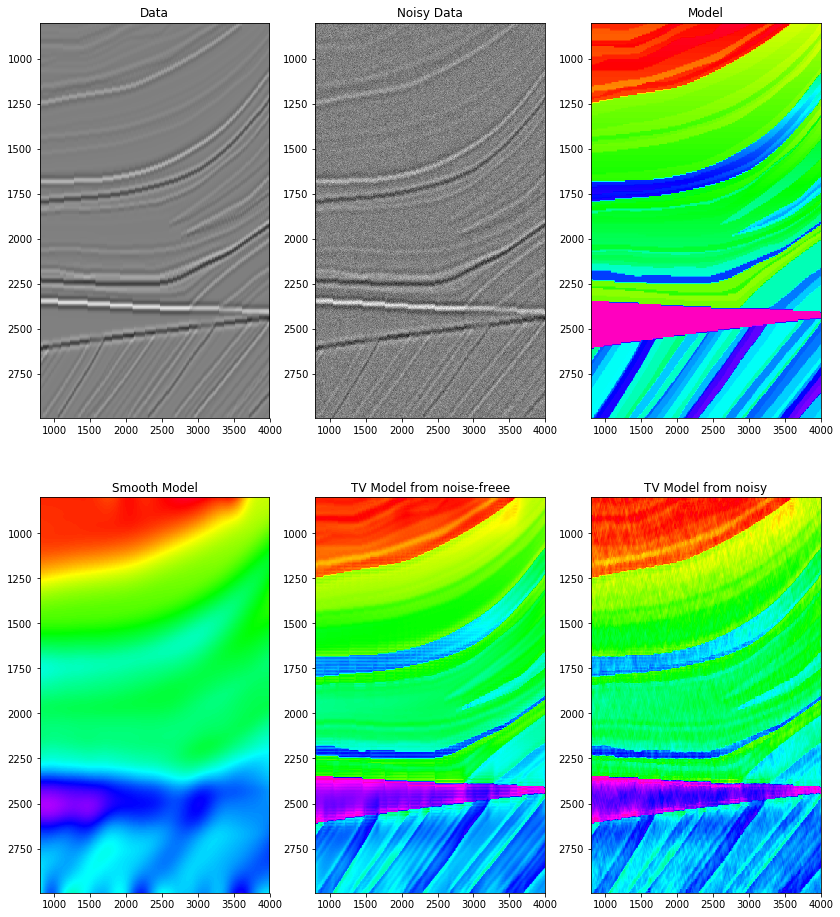

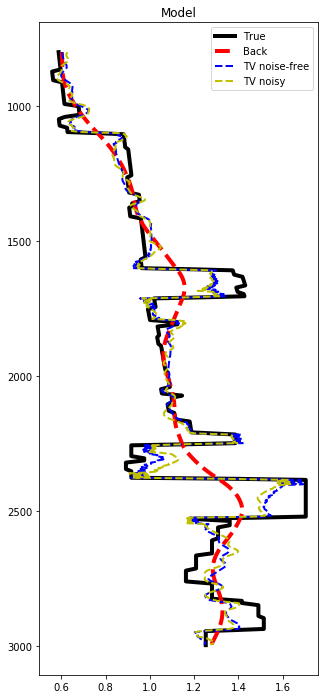

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(14,16))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][1].set_title('Noisy Data')
axs[0][1].axis('tight')

axs[0][2].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Model')
axs[0][2].axis('tight')
axs[1][0].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Smooth Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1][1].set_title('TV Model from noise-freee')
axs[1][1].axis('tight')
axs[1][2].imshow(minvn_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1][2].set_title('TV Model from noisy')
axs[1][2].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:, nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:, nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_blocky[:, nx//2], z, '--b', lw=2, label='TV noise-free')
ax.plot(minvn_blocky[:, nx//2], z, '--y', lw=2, label='TV noisy')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();